In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

import cvxpy as cvx
from gfosd import Problem 
from gfosd.components import *

np.random.seed(12) 

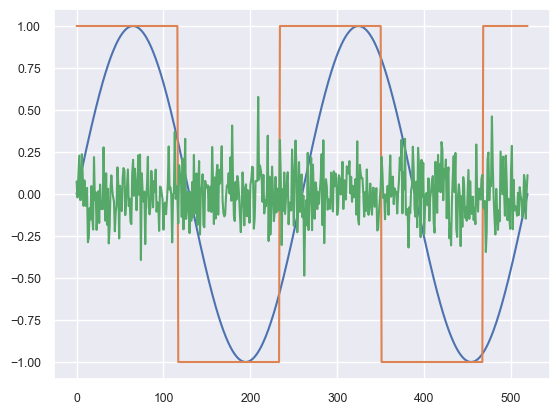

In [13]:
# t = np.linspace(0, 1000, 400)

# signal1 = np.sin(2 * np.pi * t / 365)
# signal2 = signal.square(2 * np.pi * t / 300) 

# X_real = np.zeros((3, len(t)), dtype=float)
# X_real[0] = 0.15 * np.random.randn(len(signal1))
# X_real[1] = signal1
# X_real[2] = signal2
# y = np.sum(X_real, axis=0)
# K, T = X_real.shape


np.random.seed(42)
t = np.linspace(0, 1000, 520)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape


plt.plot(signal1)
plt.plot(signal2)
plt.plot(X_real[0])

In [14]:
# Define components
c1 = SumSquare(weight=1/len(y))
# c2 = Aggregate( [SumSquare(weight=7, diff=2), AverageEqual(0, period=365), Periodic(365)] )
# c3 = Aggregate( [SumAbs(weight=0.002, diff=1), Inequality(vmax=1, vmin=-1)] )

c2 = Aggregate([
    SumSquare(weight=10, diff=2),
     Periodic(period=500)
])
c3 = Aggregate([
    SumAbs(weight=0.0015, diff=1)
    
])


# make SD problem
problem = Problem(data=y, components=[c1, c2, c3])

# Invoke solver
problem.decompose(solver="QSS")
osd_decomp_qss =  problem.decomposition

In [15]:
# Define components
c1 = SumSquare(weight=1/len(y))
c2 = Aggregate( [SumSquare(weight=7, diff=2), Periodic(500), AverageEqual(0, period=500)] )
c3 = SumAbs(weight=0.002, diff=1)

# make SD problem
problem = Problem(data=y, components=[c1, c2, c3])

# Invoke solver
problem.decompose(solver="CVX")
osd_decomp_cvx =  problem.decomposition

In [27]:
# Define components
c1 = cvx.Variable(len(y))
c2 = cvx.Variable(len(y))
c3 = cvx.Variable(len(y))

# w1 = 10
# w2 = 450
# w3 = 2.2

w1 = 1/len(y)
w2 = 7
w3 = 0.002

cost = (
   # w1 * cvx.norm(c1)
    w1 * cvx.sum_squares(c1)
    # + w2 * cvx.norm(cvx.diff(c2, k=2))
    + w2 * cvx.sum_squares(cvx.diff(c2, k=2))
    + w3 * cvx.norm1(cvx.diff(c3, k=1))
        )

# Consistency constraint
constraints = [y == c1 + c2 + c3,  cvx.sum(c2[:500]) == 0, c2[500:] - c2[:-500] == 0]

# make SD problem   
objective = cvx.Minimize(cost)
problem = cvx.Problem(objective=objective, constraints=constraints)

# Invoke solver
problem.solve(solver="MOSEK")


cvx_decomp_mosek = [c1.value, c2.value, c3.value]

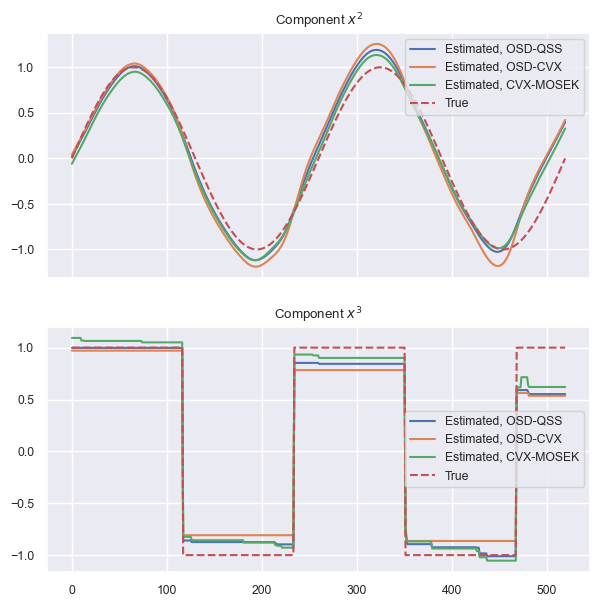

In [28]:
plot(osd_decomp_qss, osd_decomp_cvx, cvx_decomp_mosek)

In [11]:
def plot(qss_decomp_new, mosek_decomp_new, cvx_decomp_mosek):
    import seaborn as sns
    sns.set_theme()
    sns.set(font_scale=0.8)
    fig, axs = plt.subplots(2, sharex=True, figsize=(7,7))
    
    # x2: periodic
    axs[0].plot(qss_decomp_new[1], label="Estimated, OSD-QSS")
    axs[0].plot(mosek_decomp_new[1], label="Estimated, OSD-CVX")#), linewidth=1)
    axs[0].plot(cvx_decomp_mosek[1], label="Estimated, CVX-MOSEK")#, linewidth=1)
    axs[0].plot(X_real[1], label="True", linestyle="--")#, linewidth=1)
    axs[0].set_title("Component $x^2$")


    # x3: piecewise
    axs[1].plot(qss_decomp_new[2], label="Estimated, OSD-QSS")#, linewidth=1)
    axs[1].plot(mosek_decomp_new[2], label="Estimated, OSD-CVX")#, linewidth=1)
    axs[1].plot(cvx_decomp_mosek[2], label="Estimated, CVX-MOSEK")#, linewidth=1)
    axs[1].plot(X_real[2], label="True", linestyle="--")
    axs[1].set_title("Component $x^3$")

    # sum
    # axs[3].plot(qss_decomp_new.sum(axis=0), label="estimated, sdt-osd", linestyle="--", alpha=0.5, linewidth=1)
    # mosek_signal = np.array([expected_s_error_mosek,expected_s_seas_mosek,expected_s_hat_mosek])
    # axs[3].plot(mosek_signal.sum(axis=0), label="estimated, sdt-mosek", linestyle="--", alpha=0.5, linewidth=1)
    # axs[3].plot(y, label="True", linewidth=1, linestyle="--")
    # axs[3].set_title("composed signal")


    for i in range(len(axs)):
        axs[i].legend()